In [1]:
#reproducability
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import numpy as np
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import os
import glob
import pandas as pd
import keras as ks
import datetime
from scipy import stats
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

gpus = tf.config.experimental.list_physical_devices('GPU')

nl=np.array([0,130,234,330,413,492,564,626,686,742,826,898,964,1020,1075,1122,1166,1208,1248])

Using TensorFlow backend.


In [2]:
def load_Data(ns):    
    data_dir ='D:\\keras\\conduitflow'
    fname = os.path.join(data_dir, 'BTCdata_b+c.csv')

    f = open(fname)
    data = f.read()
    f.close()

    lines = data.split('\n')##以\n为分隔符，分割字符串data，形成字符串列表lines
    header = lines[0].split(',')##lines[0]为字符串，header为字符串列表
    lines = lines[1:-1]##提取字符串列表的第2至最后一个元素，形成新的列表
    
    float_data = np.zeros((len(lines), len(header)))##(1179,3)数组,元素为0
    for i, line in enumerate(lines):
    ## print(i) ##i=0时，对应line为lines的第一行
        values = [float(x) for x in line.split(',')]
        float_data[i, :] = values
    ##print(float_data[0, :])
    
    # inputs
    X_test=float_data[nl[ns-1]:nl[ns],0:3]##(55,2)  Q=0.1293L/s,c5的数据作测试样本，前两列为输入
    Y_test=float_data[nl[ns-1]:nl[ns],-1]##(55,)Q=0.1293L/s,c5的数据作测试样本，最后一列为浓度输出
    data=np.concatenate(
        [float_data[:nl[ns-1]],
         float_data[nl[ns]:]],
        axis=0)##(450,3) 剩下的450个样本做训练和验证样本
    np.random.shuffle(data)##打乱数据
    Train_data=data[:,0:3]##(450,2)#使用打乱后的450个样本作为训练和验证数据
    Train_targets=data[:,-1]##(450,)

    #scale data
    mean = Train_data.mean(axis=0)
    Train_data -= mean
    std = Train_data.std(axis=0)
    Train_data /= std

    X_test -= mean
    X_test /= std

    X_train = Train_data[0:round(0.8 * len(Train_data))]
    Y_train = Train_targets[0:round(0.8 * len(Train_targets))]
    X_stop = Train_data[round(0.8 * len(Train_data)):round(0.9 * len(Train_data))]
    Y_stop = Train_targets[round(0.8 * len(Train_targets)):round(0.9 * len(Train_targets))]
    X_opt=Train_data[round(0.9 * len(Train_data)):]
    Y_opt=Train_targets[round(0.9 * len(Train_targets)):]
    
    
    return X_train,Y_train,X_stop,Y_stop, X_opt,Y_opt,X_test,Y_test

In [3]:
def build_model(ini,GLOBAL_SETTINGS,X_train, Y_train,X_stop, Y_stop):
    # define model
    seed(ini)
    tf.random.set_seed(ini)
    model = ks.models.Sequential()
    model.add(ks.layers.Dense(GLOBAL_SETTINGS["hidden_size"], activation='relu',
                           input_shape=(X_train.shape[1],),name="dense_1"))
    model.add(ks.layers.Dense(GLOBAL_SETTINGS["hidden_size"], activation='relu',name="dense_2"))
    model.add(ks.layers.Dense(1,name="dense_3"))
    
    #optimizer = ks.optimizers.Adam(lr=GLOBAL_SETTINGS["learning_rate"], epsilon=10E-3,
                                   #clipnorm=GLOBAL_SETTINGS["clip_norm"], clipvalue=GLOBAL_SETTINGS["clip_value"])
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    # early stopping
    es = ks.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    
    model.fit(X_train, Y_train, validation_data=(X_stop, Y_stop), epochs=GLOBAL_SETTINGS["epochs"], verbose=0,
                        batch_size=GLOBAL_SETTINGS["batch_size"], callbacks=[es])
    
    return model

In [4]:
def bayesOpt_function(hiddensize, batchsize):
    hiddensize_int = int(hiddensize)
    batchsize_int = int(batchsize)

    return bayesOpt_function_with_discrete_params(hiddensize_int, batchsize_int)

In [5]:
def bayesOpt_function_with_discrete_params(hiddensize_int, batchsize_int):
    
    assert type(hiddensize_int) == int
    assert type(batchsize_int) == int
    #[...]
    
    # fixed settings for all experiments
    GLOBAL_SETTINGS = {
        'batch_size': batchsize_int,
        'clip_norm': True,
        'clip_value': 1,
        'dropout': 0,
        'epochs': 1000,
        'hidden_size': hiddensize_int,
        'learning_rate': 1e-3
    }


    #build and train model with idifferent initializations
    inimax = 5
    optresults_members = np.zeros((len(X_opt), inimax))
    #print(X_opt)#(n,2)
    #print(Y_opt)#(n,)
    for ini in range(inimax):
        print("BayesOpt-Iteration {} - ini-Ensemblemember {}".format(len(optimizer.res)+1, ini+1))
        
        # f = open('log_full.txt', "a")
        # print("BayesOpt-Iteration {} - ini-Ensemblemember {}".format(len(optimizer.res)+1, ini+1), file = f)
        # f.close()
        
        model = build_model(ini,GLOBAL_SETTINGS,X_train, Y_train, X_stop, Y_stop)  
        opt_sim= model.predict(X_opt)#(n,1)
        #opt_sim = scaler_gwl.inverse_transform(opt_sim_n)
        #optresults_members[:, ini] = opt_sim
        optresults_members[:, ini] = opt_sim.reshape(-1,)#(n,) 
    
    opt_sim_median = np.median(optresults_members,axis = 1)#(n,)    
    #sim = np.asarray(opt_sim_median.reshape(-1,1))#(n,1)
    #obs = np.asarray(Y_opt.reshape(-1,1))#(n,1)
    #err = sim-obs
    #meanTrainingGWL = np.mean(np.asarray(TrainingData['GWL']))
    #meanStopGWL = np.mean(np.asarray(StopData['GWL']))
    #err_nash = obs - np.mean([meanTrainingGWL, meanStopGWL])
    #r = stats.linregress(sim[:,0], obs[:,0])
    r = stats.linregress(Y_opt, opt_sim_median)
    
    print("total elapsed time = {}".format(datetime.datetime.now()-time1))
    print("(pp) elapsed time = {}".format(datetime.datetime.now()-time_single))
    # f = open('log_full.txt', "a")
    # print("elapsed time = {}".format(datetime.datetime.now()-time1), file = f)
    # f.close()
    
    #return (1 - ((np.sum(err ** 2)) / (np.sum((err_nash) ** 2)))) + r.rvalue ** 2 #NSE+R²: (max = 2)
    return  (r2_score(Y_opt,opt_sim_median)+r.rvalue ** 2)

In [6]:
def simulate_testset(hiddensize_int, batchsize_int):
    
    GLOBAL_SETTINGS = {
        'batch_size': batchsize_int,
        'clip_norm': True,
        'clip_value': 1,
        'dropout': 0,
        'epochs': 1000,
        'hidden_size': hiddensize_int,
        'learning_rate': 1e-3
    }

    #build and train model with idifferent initializations
    inimax = 20
    testresults_members = np.zeros((len(X_test), inimax))
    for ini in range(inimax):
        model = build_model(ini,GLOBAL_SETTINGS,X_train, Y_train, X_stop, Y_stop)  
        test_sim= model.predict(X_test)#(n,1)
        #test_sim = scaler_gwl.inverse_transform(test_sim_n)
        testresults_members[:, ini] = test_sim.reshape(-1,)#(n,) 
        #testresults_members的shape为(79,10)
    
    test_sim_median = np.median(testresults_members,axis = 1)#（n,）   
    
    #introduce GWL t-1 as additional Input (nalso needed for PI calculation)
    #GWData_shift1 = pd.DataFrame(data['GWL'])
    #GWData_shift1.index = GWData_shift1.index.shift(periods = 7, freq = 'D')
    #GWData_shift1.rename(columns={"GWL": "GWLt-1"},inplace=True)
    #PIData = GWData_shift1[(GWData_shift1.index >= GLOBAL_SETTINGS["test_start"]) & (GWData_shift1.index <= GLOBAL_SETTINGS["test_end"])]
    
    # get scores

    r = stats.linregress(Y_test, test_sim_median)#stats.linregress(a, b)和stats.linregress(b, a)结果相同
    R2 = r.rvalue ** 2
    NSE = r2_score(Y_test,test_sim_median)#sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')
    sim = np.asarray(test_sim_median.reshape(-1,1))#(n,1)
    #obs = np.asarray(scaler_gwl.inverse_transform(Y_test.reshape(-1,1)))
    obs = np.asarray(Y_test.reshape(-1,1))#(n,1)
    err = sim-obs#(n,1)
    Bias = np.mean(err)
    RMSE =  np.sqrt(np.mean(err ** 2))
    
    ##err_rel = (sim-obs)/(np.max(data['GWL'])-np.min(data['GWL']))
    #err_nash = obs - np.mean(np.asarray(data['GWL'][(data.index < GLOBAL_SETTINGS["test_start"])]))错误
    #err_nash = obs - np.mean(np.asarray(data['GWL'][(data.index >= GLOBAL_SETTINGS["test_start"]) & (data.index <= GLOBAL_SETTINGS["test_end"])]))
    #err_PI = obs-obs_PI
    #r = stats.linregress(sim[:,0], obs[:,0])
    #rRMSE = np.sqrt(np.mean(err_rel ** 2)) * 100
    #rBias = np.mean(err_rel) * 100
    #PI = 1 - ((np.sum(err ** 2)) / (np.sum((err_PI) ** 2)))
    scores = pd.DataFrame(np.array([[NSE, R2, RMSE, Bias]]),
                   columns=['NSE','R2','RMSE','Bias'])
    print(scores)

    errors = np.zeros((inimax,4))
    errors[:] = np.nan
    for i in range(inimax):
        sim = np.asarray(testresults_members[:,i].reshape(-1,1))#(n,1)
        # obs = np.asarray(scaler_gwl.inverse_transform(Y_test.reshape(-1,1)))
        err = sim-obs
        #err_rel = (sim-obs)/(np.max(data['GWL'])-np.min(data['GWL']))
        # err_nash = obs - np.mean(np.asarray(data['GWL'][(data.index < GLOBAL_SETTINGS["test_start"])]))错误
        #err_nash = obs - np.mean(np.asarray(data['GWL'][(data.index >= GLOBAL_SETTINGS["test_start"]) & (data.index <= GLOBAL_SETTINGS["test_end"])]))
        errors[i,0] = r2_score(Y_test,testresults_members[:,i])
        r = stats.linregress(sim[:,0], obs[:,0])
        errors[i,1] = r.rvalue ** 2
        errors[i,2] =  np.sqrt(np.mean(err ** 2))
        errors[i,3] = np.mean(err)
    
    sim = np.asarray(test_sim_median.reshape(-1,1))#median simulation (n,1)
    return scores, sim, obs, inimax, testresults_members, errors

In [7]:
class newJSONLogger(JSONLogger) :

      def __init__(self, path):
            self._path=None
            super(JSONLogger, self).__init__()
            self._path = path if path[-5:] == ".json" else path + ".json"

In [8]:
with tf.device("/gpu:0"): #type cpu to use cpu instead of gpu
    
    time1 = datetime.datetime.now()
    basedir = './'
    os.chdir(basedir)
    
    #for pp in range(0,17): #loop over all wells
    
    time_single = datetime.datetime.now()
    seed(1)
    tf.random.set_seed(1)
    
    ## load data
    X_train,Y_train,X_stop,Y_stop, X_opt,Y_opt,X_test,Y_test=load_Data(2)
    print(X_test)
    print(Y_test)

[[-0.89056356 -0.98732093  0.03484018]
 [-0.89056356 -0.98732093  0.0524683 ]
 [-0.89056356 -0.98732093  0.07009642]
 [-0.89056356 -0.98732093  0.08772453]
 [-0.89056356 -0.98732093  0.10535265]
 [-0.89056356 -0.98732093  0.12298076]
 [-0.89056356 -0.98732093  0.14060888]
 [-0.89056356 -0.98732093  0.15823699]
 [-0.89056356 -0.98732093  0.17586511]
 [-0.89056356 -0.98732093  0.19349323]
 [-0.89056356 -0.98732093  0.21112134]
 [-0.89056356 -0.98732093  0.22874946]
 [-0.89056356 -0.98732093  0.24637757]
 [-0.89056356 -0.98732093  0.26400569]
 [-0.89056356 -0.98732093  0.28163381]
 [-0.89056356 -0.98732093  0.29926192]
 [-0.89056356 -0.98732093  0.31689004]
 [-0.89056356 -0.98732093  0.33451815]
 [-0.89056356 -0.98732093  0.35214627]
 [-0.89056356 -0.98732093  0.36977439]
 [-0.89056356 -0.98732093  0.3874025 ]
 [-0.89056356 -0.98732093  0.40503062]
 [-0.89056356 -0.98732093  0.42265873]
 [-0.89056356 -0.98732093  0.44028685]
 [-0.89056356 -0.98732093  0.45791496]
 [-0.89056356 -0.98732093

In [9]:
# Bounded region of parameter space
    pbounds = {'hiddensize': (1, 64),
                'batchsize': (16, 256)} #constrained optimization technique, so you must specify the minimum and maximum values that can be probed for each parameter
        
    optimizer = BayesianOptimization(
                f= bayesOpt_function, #function that is optimized
                pbounds=pbounds, #opt.-range of parameters
                random_state=1, 
                verbose = 0 # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent, verbose = 2 prints everything
                )

In [10]:
#load existing optimizer
    log_already_available = 0
    if os.path.isfile("./logs_bc_b2"+".json"):
        load_logs(optimizer, logs=["./logs_bc_b2"+".json"]);
        print("\nExisting optimizer is already aware of {} points.".format(len(optimizer.space)))
        log_already_available = 1
            
    # Saving progress
    logger = newJSONLogger(path="./logs_bc_b2"+".json")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [11]:
# random exploration as a start
    f = open('./timelog_bc_b2'+'.txt', "w")
    print("Starttime of first iteration: {}\n".format(datetime.datetime.now()), file = f)#this is not looged in json file

In [12]:
    if log_already_available == 0:
            optimizer.maximize(
                init_points=25, #steps of random exploration (random starting points before bayesopt(?))
                n_iter=0, # steps of bayesian optimization
                acq="ei",# ei  = expected improvmenet (probably the most common acquisition function) 
                xi=0.05  #  Prefer exploitation (xi=0.0) / Prefer exploration (xi=0.1)
                )
        
    # optimize while improvement during last 10 steps!
    current_step = len(optimizer.res)
    beststep = False
    step = -1
    while not beststep:
        step = step + 1
        beststep = optimizer.res[step] == optimizer.max #search for best iteration step
    while current_step < 50: #below < 50 iterations, no termination
            current_step = len(optimizer.res)
            beststep = False
            step = -1
            while not beststep:
                step = step + 1
                beststep = optimizer.res[step] == optimizer.max
            print("\nbeststep {}, current step {}".format(step+1, current_step+1))
            optimizer.maximize(
                init_points=0, #steps of random exploration 
                n_iter=1, # steps of bayesian optimization
                acq="ei",# ei  = expected improvmenet (probably the most common acquisition function) 
                xi=0.05  #  Prefer exploitation (xi=0.0) / Prefer exploration (xi=0.1)
                )
                
    while (step + 20 > current_step and current_step < 150): # termination after 50 steps or after 10 steps without improvement
            current_step = len(optimizer.res)
            beststep = False
            step = -1
            while not beststep:
                step = step + 1
                beststep = optimizer.res[step] == optimizer.max
                    

            print("\nbeststep {}, current step {}".format(step+1, current_step+1))
            optimizer.maximize(
                init_points=0, #steps of random exploration
                n_iter=1, # steps of bayesian optimization
                acq="ei",# ei  = expected improvmenet (probably the most common acquisition function) 
                xi=0.05  #  Prefer exploitation (xi=0.0) / Prefer exploration (xi=0.1)
                )
            
    print("\nBEST:\t{}".format(optimizer.max))
    # for i, res in enumerate(optimizer.res):
    #     print("Iteration {}: \t{}".format(i+1, res))
            
    
        
    #best values from optimizer
    hiddensize_int = int(optimizer.max.get("params").get("hiddensize"))
    batchsize_int = int(optimizer.max.get("params").get("batchsize"))

BayesOpt-Iteration 1 - ini-Ensemblemember 1
BayesOpt-Iteration 1 - ini-Ensemblemember 2
BayesOpt-Iteration 1 - ini-Ensemblemember 3
BayesOpt-Iteration 1 - ini-Ensemblemember 4
BayesOpt-Iteration 1 - ini-Ensemblemember 5
total elapsed time = 0:00:49.771406
(pp) elapsed time = 0:00:49.771406
BayesOpt-Iteration 2 - ini-Ensemblemember 1
BayesOpt-Iteration 2 - ini-Ensemblemember 2
BayesOpt-Iteration 2 - ini-Ensemblemember 3
BayesOpt-Iteration 2 - ini-Ensemblemember 4
BayesOpt-Iteration 2 - ini-Ensemblemember 5
total elapsed time = 0:05:36.636166
(pp) elapsed time = 0:05:36.636166
BayesOpt-Iteration 3 - ini-Ensemblemember 1
BayesOpt-Iteration 3 - ini-Ensemblemember 2
BayesOpt-Iteration 3 - ini-Ensemblemember 3
BayesOpt-Iteration 3 - ini-Ensemblemember 4
BayesOpt-Iteration 3 - ini-Ensemblemember 5
total elapsed time = 0:06:54.794664
(pp) elapsed time = 0:06:54.794664
BayesOpt-Iteration 4 - ini-Ensemblemember 1
BayesOpt-Iteration 4 - ini-Ensemblemember 2
BayesOpt-Iteration 4 - ini-Ensemblememb

BayesOpt-Iteration 28 - ini-Ensemblemember 5
total elapsed time = 0:38:32.990256
(pp) elapsed time = 0:38:32.990256

beststep 20, current step 29
BayesOpt-Iteration 29 - ini-Ensemblemember 1
BayesOpt-Iteration 29 - ini-Ensemblemember 2
BayesOpt-Iteration 29 - ini-Ensemblemember 3
BayesOpt-Iteration 29 - ini-Ensemblemember 4
BayesOpt-Iteration 29 - ini-Ensemblemember 5
total elapsed time = 0:40:07.868427
(pp) elapsed time = 0:40:07.868427

beststep 20, current step 30
BayesOpt-Iteration 30 - ini-Ensemblemember 1
BayesOpt-Iteration 30 - ini-Ensemblemember 2
BayesOpt-Iteration 30 - ini-Ensemblemember 3
BayesOpt-Iteration 30 - ini-Ensemblemember 4
BayesOpt-Iteration 30 - ini-Ensemblemember 5
total elapsed time = 0:42:01.461617
(pp) elapsed time = 0:42:01.461617

beststep 20, current step 31
BayesOpt-Iteration 31 - ini-Ensemblemember 1
BayesOpt-Iteration 31 - ini-Ensemblemember 2
BayesOpt-Iteration 31 - ini-Ensemblemember 3
BayesOpt-Iteration 31 - ini-Ensemblemember 4
BayesOpt-Iteration 31 

In [13]:
#run test set simulations
t1_test = datetime.datetime.now()

In [14]:
scores, sim_med, obs, inimax, predresults_ensembles, errors_ensembles = simulate_testset(hiddensize_int, batchsize_int)#errors(20,4)
print(predresults_ensembles.shape)
print(errors_ensembles)

        NSE        R2      RMSE     Bias
0  0.831918  0.871054  0.012799  0.00112
(104, 20)
[[ 5.41353416e-01  5.81046214e-01  2.11420775e-02  1.76173007e-03]
 [ 6.44638151e-01  6.49990300e-01  1.86098974e-02  2.01837177e-03]
 [ 8.01949380e-01  8.54077592e-01  1.38930207e-02 -7.11796894e-03]
 [ 7.05463893e-01  7.61595388e-01  1.69425139e-02 -4.40422191e-04]
 [ 7.11023603e-01  7.35087456e-01  1.67818473e-02  1.81965848e-03]
 [ 5.15993741e-01  5.25475382e-01  2.17187121e-02  2.67129685e-03]
 [ 8.95978288e-01  9.04562082e-01  1.00686346e-02  1.46362098e-03]
 [ 6.59274695e-01  9.43300274e-01  1.82226181e-02  1.61705245e-02]
 [ 6.83345934e-01  7.10939814e-01  1.75671421e-02  4.92056187e-03]
 [ 8.65014048e-01  8.82307560e-01  1.14697213e-02 -3.22568819e-03]
 [ 4.45574636e-01  4.76576449e-01  2.32450307e-02  4.71049249e-03]
 [ 8.22801665e-01  8.60866342e-01  1.31413021e-02 -3.88089329e-03]
 [ 7.06888783e-01  7.45064006e-01  1.69014824e-02 -3.33821106e-03]
 [ 8.06092182e-01  8.17999731e-01  1.

In [15]:
t2_test = datetime.datetime.now()

In [16]:
f = open('./timelog_bc_b2'+'.txt', "a") 
print("Time [s] for Test-Eval(10 inis)\n{}\n".format(t2_test-t1_test), file = f)

In [17]:
for i in range(inimax):
    if errors_ensembles[i,0]==np.max(errors_ensembles[:,0]):
        maxi=i
NSE_best=r2_score(Y_test,predresults_ensembles[:, maxi])
print(NSE_best)
sim_best=np.asarray(predresults_ensembles[:, maxi].reshape(-1,1))#(n,1)
###print(obs, sim_med,sim_best,predresults_ensembles, errors_ensembles)
np.savetxt('sim_med_bc_b2'+'.csv',sim_med, delimiter=',')
np.savetxt('sim_best_bc_b2'+'.csv',sim_best, delimiter=',')
np.savetxt('pred_ensembles_bc_b2'+'.csv',predresults_ensembles, delimiter=',')
np.savetxt('error_ensembles_bc_b2'+'.csv',errors_ensembles, delimiter=',')

0.8976556118320884


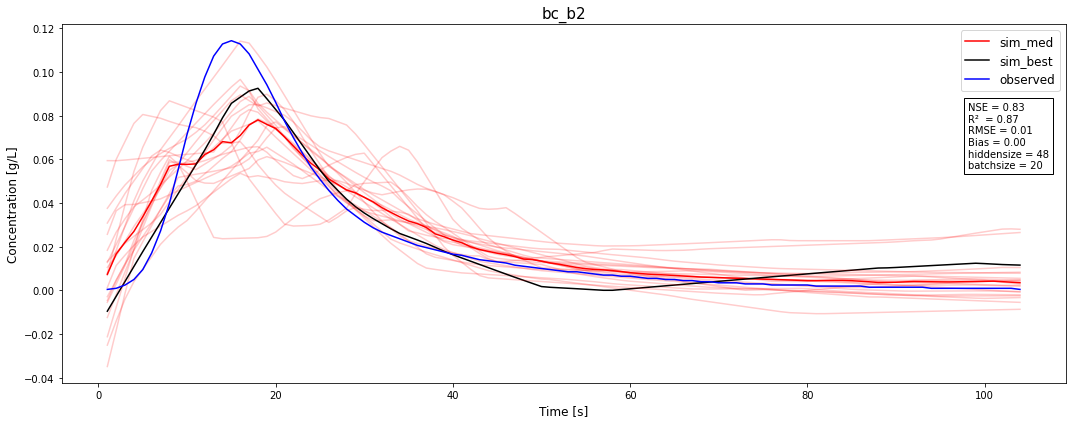

In [18]:
nums = range(1, len(obs) + 1)

pyplot.figure(figsize=(15,6))
pyplot.plot(nums, sim_med, 'r', label ="sim_med")
        
for ini in range(inimax):
    if ini==maxi:
        pyplot.plot(nums, predresults_ensembles[:, ini], 'black', label='sim_best', alpha=1)
    else:
        pyplot.plot(nums, predresults_ensembles[:, ini], 'r', label='_nolegend_', alpha=0.2)
        
pyplot.plot(nums, obs, 'b', label ="observed")
pyplot.title("bc_b2", size=15)
pyplot.ylabel('Concentration [g/L]', size=12)
pyplot.xlabel('Time [s]',size=12)
pyplot.legend(fontsize=12,bbox_to_anchor=(1, 1),loc='upper right')
pyplot.tight_layout()

s = """NSE = {:.2f}\nR²  = {:.2f}\nRMSE = {:.2f}\nBias = {:.2f}\nhiddensize = {:d}\nbatchsize = {:d}""".format(scores.NSE[0],scores.R2[0],
        scores.RMSE[0],scores.Bias[0],hiddensize_int,batchsize_int)

pyplot.figtext(0.9, 0.6, s, bbox=dict(facecolor='white'))
pyplot.savefig('bc_b2.png', dpi=300)
pyplot.show()

In [19]:
print(scores.NSE)

0    0.831918
Name: NSE, dtype: float64


In [20]:
# print log summary file
f = open('./log_summary_bc_b2'+'.txt', "w", encoding= "utf-8")
print("\nBEST:\n\n"+s+"\n", file = f)
print("best iteration = {}".format(step+1), file = f)
print("max iteration = {}\n".format(len(optimizer.res)), file = f)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \t{}".format(i+1, res), file = f) 
f.close()

#print ensemble member errors
np.savetxt('./errors_ensembles_abc_a5'+'.txt',errors_ensembles,delimiter=';',header = 'NSE;R²;RMSE;Bias', fmt = '%.4f', encoding= "utf-8")
        
#print sim data
printdf = pd.DataFrame(data=predresults_ensembles,index=nums)
printdf.to_csv('./pred_ensembles_abc_a5'+'.txt',sep=';')